In [17]:
import pandas as pd
from transformers import BertTokenizer, BertModel
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import BertModel, BertTokenizer
import torch
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import nltk
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from scipy.spatial.distance import cosine
from sklearn.model_selection import train_test_split
from nltk.stem import WordNetLemmatizer
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import classification_report

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\dcocu\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [18]:
# Input e pulizia dataset
dataset = pd.read_csv('dataset/twitter.csv')

column_name_to_drop = 'Borderlands'

columns_to_drop = ['2401', 'Borderlands']
dataset = dataset.drop(columns=columns_to_drop, errors='ignore')

old_column_name = 'im getting on borderlands and i will murder you all ,'
new_column_name = 'Text'

if old_column_name in dataset.columns:
    dataset.rename(columns={old_column_name: new_column_name}, inplace=True)
    
old_column_name = 'Positive'
new_column_name = 'Sentiment'

if old_column_name in dataset.columns:
    dataset.rename(columns={old_column_name: new_column_name}, inplace=True)

columns_mapping = {
    'Irrelevant': 'Sentiment',
    'I mentioned on Facebook that I was struggling for motivation to go for a run the other day, which has been translated by Tom’s great auntie as ‘Hayley can’t get out of bed’ and told to his grandma, who now thinks I’m a lazy, terrible person 🤣': 'Texts'
}


dataset = dataset[dataset['Sentiment'].isin(['Positive', 'Negative', 'Neutral'])].copy()

dataset

,Sentiment,Text
0,Positive,I am coming to the borders and I will kill you...
1,Positive,im getting on borderlands and i will kill you ...
2,Positive,im coming on borderlands and i will murder you...
3,Positive,im getting on borderlands 2 and i will murder ...
4,Positive,im getting into borderlands and i can murder y...
...,...,...
74676,Positive,Just realized that the Windows partition of my...
74677,Positive,Just realized that my Mac window partition is ...
74678,Positive,Just realized the windows partition of my Mac ...
74679,Positive,Just realized between the windows partition of...


In [19]:
dataset.shape

(61691, 2)

In [20]:
# Eliminazione valori con caratteri speciali
dataset['Text'] = dataset['Text'].str.replace(r'http\S+', '', regex=True)  # Rimuove URL
dataset['Text'] = dataset['Text'].str.replace(r'@\w+', '', regex=True)  # Rimuove le menzioni
dataset['Text'] = dataset['Text'].str.replace(r'[^A-Za-z0-9 ]+', '', regex=True)  # Rimuove caratteri speciali
dataset.dropna(subset=['Text'], inplace=True)
dataset = dataset[dataset['Text'] != '']

In [22]:
# Riduco il dataset perché troppo grande
dataset = dataset.sample(10)
dataset.shape

(10, 2)

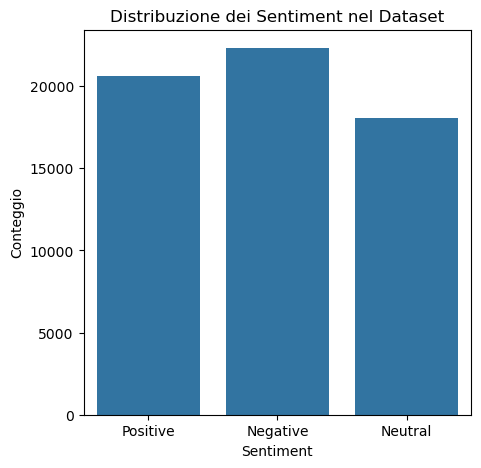

In [5]:
plt.figure(figsize=(5, 5))
sns.countplot(data=dataset, x='Sentiment', order=['Positive', 'Negative', 'Neutral'])
plt.title('Distribuzione dei Sentiment nel Dataset')
plt.xlabel('Sentiment')
plt.ylabel('Conteggio')
plt.show()

In [23]:
sentiment_counts = dataset['Sentiment'].value_counts()

total = sentiment_counts.sum()
sentiment_proportions = (sentiment_counts / total) * 100

print("Conteggi dei sentimenti:")
print(sentiment_counts)

print("\nProporzione (%):")
print(sentiment_proportions)

max_proportion = sentiment_proportions.max()
min_proportion = sentiment_proportions.min()
difference = max_proportion - min_proportion

print(f"\nDifferenza massima tra classi: {difference:.2f}%")

# Conclusione
threshold = 10  # Soglia del 10% per considerare il dataset bilanciato
if difference <= threshold:
    print("Il dataset è bilanciato.")
else:
    print("Il dataset NON è bilanciato.")


Conteggi dei sentimenti:
Sentiment
Neutral     4
Positive    3
Negative    3
Name: count, dtype: int64

Proporzione (%):
Sentiment
Neutral     40.0
Positive    30.0
Negative    30.0
Name: count, dtype: float64

Differenza massima tra classi: 10.00%
Il dataset è bilanciato.


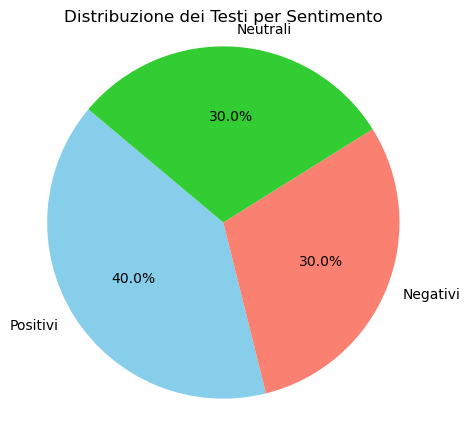

In [24]:
sizes = sentiment_counts.values
labels = ['Positivi', 'Negativi', 'Neutrali']
colors = ['skyblue', 'salmon', 'limegreen']

plt.figure(figsize=(5, 5))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Distribuzione dei Testi per Sentimento')
plt.axis('equal')  # Mantiene proporzioni uniformi per il cerchio.

plt.show()


In [25]:
dataset.to_csv('dataset/dataset_filtered.csv', index=False)

In [26]:
dataset = pd.read_csv('dataset/dataset_filtered.csv')
dataset

,Sentiment,Text
0,Neutral,Michelle Obama and the Stephenson And Johnson ...
1,Positive,Red Dead Redemption 2 Blind story playthrough...
2,Positive,Community With the TV hype leveling off I thin...
3,Negative,i purchased their R6 000 credits 20 minutes ...
4,Neutral,Anyone that plays a bad luck albatross deck in...
5,Neutral,Me How haha unk
6,Negative,THIS WORKING
7,Positive,Oh damned yes Adalid
8,Neutral,Cute woman Plays just occasionally sassy regul...
9,Negative,velkoz i hate velkoz hes the worst champ to ev...


In [10]:
# lessico
lessico = []
with open('lessico/subjclueslen1-HLTEMNLP05.tff', 'r') as file:
    for line in file:
        entries = line.strip().split()
        
        
        valid_entries = [e for e in entries if '=' in e]
        
        
        entry_dict = {e.split('=')[0]: e.split('=')[1] for e in valid_entries}
        
       
        if entry_dict:
            lessico.append(entry_dict)

print(lessico)

[{'type': 'weaksubj', 'len': '1', 'word1': 'abandoned', 'pos1': 'adj', 'stemmed1': 'n', 'priorpolarity': 'negative'}, {'type': 'weaksubj', 'len': '1', 'word1': 'abandonment', 'pos1': 'noun', 'stemmed1': 'n', 'priorpolarity': 'negative'}, {'type': 'weaksubj', 'len': '1', 'word1': 'abandon', 'pos1': 'verb', 'stemmed1': 'y', 'priorpolarity': 'negative'}, {'type': 'strongsubj', 'len': '1', 'word1': 'abase', 'pos1': 'verb', 'stemmed1': 'y', 'priorpolarity': 'negative'}, {'type': 'strongsubj', 'len': '1', 'word1': 'abasement', 'pos1': 'anypos', 'stemmed1': 'y', 'priorpolarity': 'negative'}, {'type': 'strongsubj', 'len': '1', 'word1': 'abash', 'pos1': 'verb', 'stemmed1': 'y', 'priorpolarity': 'negative'}, {'type': 'weaksubj', 'len': '1', 'word1': 'abate', 'pos1': 'verb', 'stemmed1': 'y', 'priorpolarity': 'negative'}, {'type': 'weaksubj', 'len': '1', 'word1': 'abdicate', 'pos1': 'verb', 'stemmed1': 'y', 'priorpolarity': 'negative'}, {'type': 'strongsubj', 'len': '1', 'word1': 'aberration', 'po

In [11]:
# lessico
lessico = pd.DataFrame(lessico)

lessico.to_csv('lessico/lessico.csv', index=False)

print("Il file CSV 'lessico.csv' è stato creato con successo!")

Il file CSV 'lessico.csv' è stato creato con successo!


In [12]:
# lessico
lessico = pd.read_csv('lessico/lessico.csv')
filtered_lexicon = lessico[['word1', 'priorpolarity']]

filtered_lexicon = filtered_lexicon[filtered_lexicon['priorpolarity'].isin(['positive', 'negative', 'neutral'])].copy()

print(filtered_lexicon.head())

filtered_lexicon.to_csv('lessico/filtered_lexicon.csv', index=False)
print("Il file CSV 'filtered_lexicon.csv' è stato creato con le colonne word1 e polarity.")

         word1 priorpolarity
0    abandoned      negative
1  abandonment      negative
2      abandon      negative
3        abase      negative
4    abasement      negative
Il file CSV 'filtered_lexicon.csv' è stato creato con le colonne word1 e polarity.


In [13]:
# lessico
filtered_lexicon = pd.read_csv('lessico/filtered_lexicon.csv')

sentiment_counts = filtered_lexicon['priorpolarity'].value_counts()

total = sentiment_counts.sum()
sentiment_proportions = (sentiment_counts / total) * 100

print("Conteggi dei sentimenti:")
print(sentiment_counts)

print("\nProporzione (%):")
print(sentiment_proportions)

max_proportion = sentiment_proportions.max()
min_proportion = sentiment_proportions.min()
difference = max_proportion - min_proportion

print(f"\nDifferenza massima tra classi: {difference:.2f}%")

# Conclusione
threshold = 10  # Soglia del 10% per considerare il dataset bilanciato
if difference <= threshold:
    print("Il dataset è bilanciato.")
else:
    print("Il dataset NON è bilanciato.")

Conteggi dei sentimenti:
priorpolarity
negative    4912
positive    2718
neutral      570
Name: count, dtype: int64

Proporzione (%):
priorpolarity
negative    59.902439
positive    33.146341
neutral      6.951220
Name: count, dtype: float64

Differenza massima tra classi: 52.95%
Il dataset NON è bilanciato.


In [14]:
# Ricavare gli embedding del lessico
import pandas as pd
import numpy as np
from transformers import BertTokenizer, BertModel
import torch


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased').to(device)


def process_text_with_bert(text):
   
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=512)
    inputs = {key: value.to(device) for key, value in inputs.items()}
    
    
    with torch.no_grad():
        outputs = model(**inputs)
    
    
    embeddings = outputs.last_hidden_state
    sentence_embedding = embeddings.mean(dim=1)  
    
    return sentence_embedding.cpu().numpy()


csv_output_path = 'lessico/lessico_metadata.csv'
npy_output_path = 'lessico/embeddings.npy'


filtered_lexicon = pd.read_csv('lessico/filtered_lexicon.csv')


embeddings_list = []
metadata = []

for _, row in filtered_lexicon.iterrows():
    word = row['word1']
    embedding = process_text_with_bert(word)
    
    embeddings_list.append(embedding)
    metadata.append({'word1': word})


np.save(npy_output_path, np.array(embeddings_list))


metadata_df = pd.DataFrame(metadata)
metadata_df.to_csv(csv_output_path, index=False)

print(f"Metadati salvati in: {csv_output_path}")
print(f"Embedding salvati in: {npy_output_path}")

Metadati salvati in: lessico/lessico_metadata.csv
Embedding salvati in: lessico/embeddings.npy


In [15]:
# Trovare l'embedding di una parola del lessico
import numpy as np
import pandas as pd

csv_path = 'lessico/filtered_lexicon.csv'
npy_path = 'lessico/embeddings.npy'

lexicon_df = pd.read_csv(csv_path)
embeddings = np.load(npy_path, allow_pickle=True)

def get_embedding(word, lexicon_df, embeddings):
    try:
        index = lexicon_df[lexicon_df['word1'] == word].index[0]
        embedding = embeddings[index]
        return embedding
    except IndexError:
        print(f"La parola '{word}' non è presente nel lessico.")
        return None

word = 'abandoned'
embedding = get_embedding(word, lexicon_df, embeddings)

if embedding is not None:
    print(f"Embedding per la parola '{word}':\n{embedding}")


Embedding per la parola 'abandoned':
[[-1.72239542e-03  4.28452380e-02 -2.86465079e-01  1.07006110e-01
  -2.66421940e-02 -1.02810748e-01  2.64530152e-01  1.49719119e-02
   9.15656518e-03 -8.56780186e-02 -1.17214859e-01 -1.65132508e-01
   2.52979924e-03  3.34328860e-01 -2.33707592e-01 -4.14187431e-01
  -2.64722388e-02 -4.31856625e-02  2.24438190e-01  2.82989383e-01
   5.00435121e-02 -1.26765594e-01  1.70628384e-01 -7.85127357e-02
   8.29721522e-03  1.97753564e-01 -2.00308010e-01 -1.75495967e-01
  -3.24958593e-01  5.70172779e-02  8.43479205e-03 -1.61016002e-01
   8.81313980e-02  2.71162301e-01 -7.74895176e-02 -1.70144841e-01
   2.51879424e-01  1.17479758e-02 -3.73057574e-01  1.83194876e-02
  -2.28475168e-01  8.96541849e-02  1.33453503e-01  1.30757347e-01
  -1.10111378e-01 -6.34770095e-02  2.43751228e-01  4.54851873e-02
  -1.79277018e-01  1.80419907e-01 -3.87693852e-01  3.92591953e-03
   2.57839262e-01  2.37422511e-01  1.00812085e-01  2.18443945e-01
   3.20977956e-01  9.38722566e-02  6.96

In [27]:
# Ricava gli embedding del dataset
import numpy as np
import pandas as pd
from transformers import BertTokenizer, BertModel
import torch


tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


csv_output_path = 'token/token_metadata.csv'
npy_output_path = 'token/token_embeddings.npy'

dataset = pd.read_csv('dataset/dataset_filtered.csv')
dataset['Text'] = dataset['Text'].astype(str).fillna('')


metadata = []
all_embeddings = []

for index, row in dataset.iterrows():
    sentiment = row['Sentiment']
    text = row['Text']
    
    
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True).to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    
   
    token_embeddings = outputs.last_hidden_state.squeeze(0).cpu().numpy() 
    tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"].squeeze(0).cpu().numpy())
    
    
    for token, embedding in zip(tokens, token_embeddings):
        metadata.append({
            'Sentiment': sentiment,
            'Text': text,
            'Token': token
        })
        all_embeddings.append(embedding)


metadata_df = pd.DataFrame(metadata)
metadata_df.to_csv(csv_output_path, index=False)


np.save(npy_output_path, np.array(all_embeddings))

print(f"Metadati salvati in: {csv_output_path}")
print(f"Embedding salvati in: {npy_output_path}")


Metadati salvati in: token/token_metadata.csv
Embedding salvati in: token/token_embeddings.npy


In [29]:
# (Embedding Contestuali) Assegna alla parola il sentimento più presente nella parola più vicina rispetto la similarità del coseno
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity


csv_path = 'token/token_metadata.csv'  
npy_path = 'token/token_embeddings.npy'  

dataset = pd.read_csv('dataset/dataset_filtered.csv')   
metadata_dataset = pd.read_csv(csv_path)
embeddings_dataset = np.load(npy_path)


csv_path_lessico = 'lessico/filtered_lexicon.csv'
npy_path_lessico = 'lessico/embeddings.npy'

lessico = pd.read_csv(csv_path_lessico)
embeddings_lessico = np.load(npy_path_lessico, allow_pickle=True)



def find_best_match(embedding_token, embeddings_lessico, lessico):
    max_similarity = -1
    best_match = None
    best_embedding = None

    for idx, embedding_lessico in enumerate(embeddings_lessico):
        similarity = cosine_similarity(
            embedding_token.reshape(1, -1), embedding_lessico.reshape(1, -1)
        )[0, 0]
        if similarity > max_similarity:
            max_similarity = similarity
            best_match = lessico.iloc[idx]['word1']
            best_embedding = embedding_lessico
            priorpolarity = lessico.iloc[idx]['priorpolarity']

    return best_match, max_similarity, best_embedding, priorpolarity


positivi = 0
negativi = 0
neutrali = 0
corrispondenti = 0
sentiment_assegnato = ''

metadata_dataset.sample(n=100, random_state=42) # Prendiamo un campione di 100 righe
for index, row in metadata_dataset.iterrows():

    sentence = row['Text']
    sentiment = row['Sentiment']
    token = row['Token']    
    embedding_token = embeddings_dataset[index] 



    if(token == '[CLS]'):
        positivi = 0
        negativi = 0
        neutrali = 0
        continue

    elif (token == '[SEP]'):
        print(f"La frase '{sentence}' \nha positivi: {positivi}, negativi: {negativi}, neutrali: {neutrali}")
        
        if(positivi > negativi and positivi > neutrali):
            sentiment_assegnato = 'Positive'
        elif(negativi > positivi and negativi > neutrali):  
            sentiment_assegnato = 'Negative'
        else:    
            sentiment_assegnato = 'Neutral'

        if (sentiment_assegnato == sentiment):
            corrispondenti += 1
        
        print(f"Sentimento assegnato: {sentiment_assegnato}")
        print(f"Sentimento reale: {sentiment}\n")

        continue
        
    best_match, max_similarity, best_embedding, priorpolarity = find_best_match(embedding_token, embeddings_lessico, lessico)

    if priorpolarity == 'positive':
        positivi += 1   
    elif priorpolarity == 'negative':   
        negativi += 1 
    elif priorpolarity == 'neutral':        
        neutrali += 1


print(f"Corrispondenze: {corrispondenti}/{len(dataset)}")
    

La frase 'Michelle Obama and the Stephenson And Johnson T Gorsky 5 Billion Medicare Omnicare Medicaid Scandal Uh Michelle attended HOSPITAL IC in Chicago where original case broke johnsonandtoxincommichelleobama' 
ha positivi: 6, negativi: 34, neutrali: 2
Sentimento assegnato: Negative
Sentimento reale: Neutral

La frase 'Red Dead Redemption 2  Blind story playthrough  Chilling killing twitchtvowenjd' 
ha positivi: 6, negativi: 12, neutrali: 0
Sentimento assegnato: Negative
Sentimento reale: Positive

La frase 'Community With the TV hype leveling off I think for a perfect time me declare that Jessica may be our next mont your uthatonejoestar redditcomrzoemainscom' 
ha positivi: 7, negativi: 30, neutrali: 2
Sentimento assegnato: Negative
Sentimento reale: Positive

La frase ' i purchased their R6 000 credits 20  minutes ago and the whole money and purchase have gone through but already the credits just havent appeared on top my account But Iu ve never seen it it take this long and im a 

In [54]:
# (Embedding Contestuali) Assegnamo il sentimento più comune tra i k token più simili (K-NN), con k=3
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from collections import Counter

csv_path = 'token/token_metadata.csv'  
npy_path = 'token/token_embeddings.npy'  

metadata_dataset = pd.read_csv(csv_path)
embeddings_dataset = np.load(npy_path)
dataset = pd.read_csv('dataset/dataset_filtered.csv')

csv_path_lessico = 'lessico/filtered_lexicon.csv'
npy_path_lessico = 'lessico/embeddings.npy'

lessico = pd.read_csv(csv_path_lessico)
embeddings_lessico = np.load(npy_path_lessico, allow_pickle=True)

def find_best_match_knn(embedding_token, embeddings_lessico, lessico, k=3):
    similarities = []

    for idx, embedding_lessico in enumerate(embeddings_lessico):
        similarity = cosine_similarity(
            embedding_token.reshape(1, -1), embedding_lessico.reshape(1, -1)
        )[0, 0]
        similarities.append((similarity, idx))

    
    top_k = sorted(similarities, key=lambda x: x[0], reverse=True)[:k]

    
    priorpolarities = [lessico.iloc[idx]['priorpolarity'] for _, idx in top_k]

    
    most_common_priorpolarity = Counter(priorpolarities).most_common(1)[0][0]

   
    best_similarity, best_idx = top_k[0]
    best_match = lessico.iloc[best_idx]['word1']
    best_embedding = embeddings_lessico[best_idx]

    return best_match, best_similarity, best_embedding, most_common_priorpolarity

positivi = 0
negativi = 0
neutrali = 0
corrispondenti = 0
sentiment_assegnato = ''


for index, row in metadata_dataset.iterrows():

    sentence = row['Text']
    sentiment = row['Sentiment']
    token = row['Token']    
    embedding_token = embeddings_dataset[index] 

    if(token == '[CLS]'):
        positivi = 0
        negativi = 0
        neutrali = 0
        continue

    elif (token == '[SEP]'):
        print(f"La frase '{sentence}' \nha positivi: {positivi}, negativi: {negativi}, neutrali: {neutrali}")
        

        if(positivi > negativi and positivi > neutrali):
            sentiment_assegnato = 'Positive'
        elif(negativi > positivi and negativi > neutrali):  
            sentiment_assegnato = 'Negative'
        else:    
            sentiment_assegnato = 'Neutral'

        if (sentiment_assegnato == sentiment):
            corrispondenti += 1

        print(f"Sentimento assegnato: {sentiment_assegnato}")
        print(f"Sentimento reale: {sentiment}\n")

        continue
        
    best_match, max_similarity, best_embedding, priorpolarity = find_best_match_knn(embedding_token, embeddings_lessico, lessico, k=3)

    if priorpolarity == 'positive':
        positivi += 1   
    elif priorpolarity == 'negative':   
        negativi += 1 
    elif priorpolarity == 'neutral':        
        neutrali += 1

print(f"Corrispondenze: {corrispondenti}/{len(dataset)}")

La frase 'Twitter and Facebook are places that share information thoughts calls to just be heard  There is no place for these platforms to silence the people  Speech and any laws that is not abided to that violate the 1st Amendment is a crime Crime will be penalties' 
ha positivi: 3, negativi: 42, neutrali: 2
Sentimento assegnato: Negative
Sentimento reale: Negative
La frase 'I truly felt good deleting ppl with boy scout in an 3p like version but that was finally 1st day of the ranked game u gotta believe meunk no gun should be this OP' 
ha positivi: 3, negativi: 35, neutrali: 1
Sentimento assegnato: Negative
Sentimento reale: Neutral
La frase 'So apparently if you hit it doesnt show you meters sooooooo we gone have to estimate now boys Please Fix  and your game is perfect' 
ha positivi: 7, negativi: 20, neutrali: 2
Sentimento assegnato: Negative
Sentimento reale: Negative
La frase 'Fix the Soundbugs    Its terrible' 
ha positivi: 0, negativi: 6, neutrali: 1
Sentimento assegnato: Negat

In [ ]:
# Calcolo embedding non contestuali del dataset
import pandas as pd
import numpy as np
from transformers import BertTokenizer, BertModel
import torch


model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name)
model.eval()


csv_input_path = 'dataset/dataset_filtered.csv'
csv_output_path = 'token/token_metadata_non_contestuali.csv'
npy_output_path = 'token/token_embeddings_non_contestuali.npy'


dataset = pd.read_csv(csv_input_path)
dataset['Text'] = dataset['Text'].astype(str).fillna('')


metadata = []
all_embeddings = []


for index, row in dataset.iterrows():
    sentiment = row['Sentiment']
    text = row['Text']
    
    
    encoded_input = tokenizer(text, return_tensors='pt', padding=True, truncation=True)
    
    with torch.no_grad():
        embeddings = model.embeddings.word_embeddings(encoded_input['input_ids']).squeeze(0).cpu().numpy()
    
    
    tokens = tokenizer.convert_ids_to_tokens(encoded_input['input_ids'].squeeze(0).cpu().numpy())
    
    
    for token, embedding in zip(tokens, embeddings):
        metadata.append({
            'Sentiment': sentiment,
            'Text': text,
            'Token': token
        })
        all_embeddings.append(embedding)


metadata_df = pd.DataFrame(metadata)
metadata_df.to_csv(csv_output_path, index=False)


np.save(npy_output_path, np.array(all_embeddings))

print(f"Metadati salvati in: {csv_output_path}")
print(f"Embedding salvati in: {npy_output_path}")


Metadati salvati in: token/token_metadata_non_contestuali.csv
Embedding salvati in: token/token_embeddings_non_contestuali.npy


In [3]:
# (Embedding non Contestuali) Assegna alla parola il sentimento più presente nella parola più vicina rispetto la similarità del coseno
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity


csv_path = 'token/token_metadata_non_contestuali.csv'  
npy_path = 'token/token_embeddings_non_contestuali.npy'  


metadata_dataset = pd.read_csv(csv_path)
embeddings_dataset = np.load(npy_path)
dataset = pd.read_csv('dataset/dataset_filtered.csv')


csv_path_lessico = 'lessico/filtered_lexicon.csv'
npy_path_lessico = 'lessico/embeddings.npy'

lessico = pd.read_csv(csv_path_lessico)
embeddings_lessico = np.load(npy_path_lessico, allow_pickle=True)



def find_best_match(embedding_token, embeddings_lessico, lessico):
    max_similarity = -1
    best_match = None
    best_embedding = None

    for idx, embedding_lessico in enumerate(embeddings_lessico):
        similarity = cosine_similarity(
            embedding_token.reshape(1, -1), embedding_lessico.reshape(1, -1)
        )[0, 0]
        if similarity > max_similarity:
            max_similarity = similarity
            best_match = lessico.iloc[idx]['word1']
            best_embedding = embedding_lessico
            priorpolarity = lessico.iloc[idx]['priorpolarity']

    return best_match, max_similarity, best_embedding, priorpolarity


positivi = 0
negativi = 0
neutrali = 0
corrispondenti = 0
sentiment_assegnato = ''


for index, row in metadata_dataset.iterrows():

    sentence = row['Text']
    sentiment = row['Sentiment']
    token = row['Token']    
    embedding_token = embeddings_dataset[index] 

    if(token == '[CLS]'):
        positivi = 0
        negativi = 0
        neutrali = 0
        continue

    elif (token == '[SEP]'):
        print(f"La frase '{sentence}' \nha positivi: {positivi}, negativi: {negativi}, neutrali: {neutrali}")
        
        if(positivi > negativi and positivi > neutrali):
            sentiment_assegnato = 'Positive'
        elif(negativi > positivi and negativi > neutrali):  
            sentiment_assegnato = 'Negative'
        else:    
            sentiment_assegnato = 'Neutral'

        if (sentiment_assegnato == sentiment):
            corrispondenti += 1

        print(f"Sentimento assegnato: {sentiment_assegnato}")
        print(f"Sentimento reale: {sentiment}\n")

        continue
        
    best_match, max_similarity, best_embedding, priorpolarity = find_best_match(embedding_token, embeddings_lessico, lessico)

    if priorpolarity == 'positive':
        positivi += 1   
    elif priorpolarity == 'negative':   
        negativi += 1 
    elif priorpolarity == 'neutral':        
        neutrali += 1


print(f"Corrispondenze: {corrispondenti}/{len(dataset)}")

La frase 'Twitter and Facebook are places that share information thoughts calls to just be heard  There is no place for these platforms to silence the people  Speech and any laws that is not abided to that violate the 1st Amendment is a crime Crime will be penalties' 
ha positivi: 9, negativi: 37, neutrali: 1
Sentimento assegnato: Negative
Sentimento reale: Negative

La frase 'I truly felt good deleting ppl with boy scout in an 3p like version but that was finally 1st day of the ranked game u gotta believe meunk no gun should be this OP' 
ha positivi: 14, negativi: 24, neutrali: 1
Sentimento assegnato: Negative
Sentimento reale: Neutral

La frase 'So apparently if you hit it doesnt show you meters sooooooo we gone have to estimate now boys Please Fix  and your game is perfect' 
ha positivi: 8, negativi: 17, neutrali: 4
Sentimento assegnato: Negative
Sentimento reale: Negative

La frase 'Fix the Soundbugs    Its terrible' 
ha positivi: 2, negativi: 4, neutrali: 1
Sentimento assegnato: N

In [4]:
# (Embedding non Contestuali) Assegnamo il sentimento più comune tra i k token più simili
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from collections import Counter

csv_path = 'token/token_metadata_non_contestuali.csv'  
npy_path = 'token/token_embeddings_non_contestuali.npy'  

metadata_dataset = pd.read_csv(csv_path)
embeddings_dataset = np.load(npy_path)
dataset = pd.read_csv('dataset/dataset_filtered.csv')

csv_path_lessico = 'lessico/filtered_lexicon.csv'
npy_path_lessico = 'lessico/embeddings.npy'

lessico = pd.read_csv(csv_path_lessico)
embeddings_lessico = np.load(npy_path_lessico, allow_pickle=True)

def find_best_match_knn(embedding_token, embeddings_lessico, lessico, k=3):
    similarities = []

    for idx, embedding_lessico in enumerate(embeddings_lessico):
        similarity = cosine_similarity(
            embedding_token.reshape(1, -1), embedding_lessico.reshape(1, -1)
        )[0, 0]
        similarities.append((similarity, idx))

    
    top_k = sorted(similarities, key=lambda x: x[0], reverse=True)[:k]

    
    priorpolarities = [lessico.iloc[idx]['priorpolarity'] for _, idx in top_k]

    
    most_common_priorpolarity = Counter(priorpolarities).most_common(1)[0][0]

   
    best_similarity, best_idx = top_k[0]
    best_match = lessico.iloc[best_idx]['word1']
    best_embedding = embeddings_lessico[best_idx]

    return best_match, best_similarity, best_embedding, most_common_priorpolarity

positivi = 0
negativi = 0
neutrali = 0
corrispondenti = 0
sentiment_assegnato = ''


for index, row in metadata_dataset.iterrows():

    sentence = row['Text']
    sentiment = row['Sentiment']
    token = row['Token']    
    embedding_token = embeddings_dataset[index] 

    if(token == '[CLS]'):
        positivi = 0
        negativi = 0
        neutrali = 0
        continue

    elif (token == '[SEP]'):
        print(f"La frase '{sentence}' \nha positivi: {positivi}, negativi: {negativi}, neutrali: {neutrali}")
        

        if(positivi > negativi and positivi > neutrali):
            sentiment_assegnato = 'Positive'
        elif(negativi > positivi and negativi > neutrali):  
            sentiment_assegnato = 'Negative'
        else:    
            sentiment_assegnato = 'Neutral'

        if (sentiment_assegnato == sentiment):
            corrispondenti += 1

        print(f"Sentimento assegnato: {sentiment_assegnato}")
        print(f"Sentimento reale: {sentiment}")

        continue
        
    best_match, max_similarity, best_embedding, priorpolarity = find_best_match_knn(embedding_token, embeddings_lessico, lessico, k=3)

    if priorpolarity == 'positive':
        positivi += 1   
    elif priorpolarity == 'negative':   
        negativi += 1 
    elif priorpolarity == 'neutral':        
        neutrali += 1

print(f"Corrispondenze: {corrispondenti}/{len(dataset)}")

La frase 'Twitter and Facebook are places that share information thoughts calls to just be heard  There is no place for these platforms to silence the people  Speech and any laws that is not abided to that violate the 1st Amendment is a crime Crime will be penalties' 
ha positivi: 8, negativi: 39, neutrali: 0
Sentimento assegnato: Negative
Sentimento reale: Negative
La frase 'I truly felt good deleting ppl with boy scout in an 3p like version but that was finally 1st day of the ranked game u gotta believe meunk no gun should be this OP' 
ha positivi: 9, negativi: 28, neutrali: 2
Sentimento assegnato: Negative
Sentimento reale: Neutral
La frase 'So apparently if you hit it doesnt show you meters sooooooo we gone have to estimate now boys Please Fix  and your game is perfect' 
ha positivi: 6, negativi: 19, neutrali: 4
Sentimento assegnato: Negative
Sentimento reale: Negative
La frase 'Fix the Soundbugs    Its terrible' 
ha positivi: 2, negativi: 4, neutrali: 1
Sentimento assegnato: Negat

In [2]:
# (Embedding Contestuali) Presa una frase da input ritorna il sentiment con K-NN basandosi sul lessico
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from collections import Counter
from transformers import BertTokenizer, BertModel
import torch


csv_path_lessico = 'lessico/filtered_lexicon.csv'
npy_path_lessico = 'lessico/embeddings.npy'

lessico = pd.read_csv(csv_path_lessico)
embeddings_lessico = np.load(npy_path_lessico, allow_pickle=True)


model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name)
model.eval()

def get_priorpolarity(word, lessico):
    result = lessico[lessico['word1'] == word]
    if not result.empty:
        return result.iloc[0]['priorpolarity']
    else:
        return None


def find_best_match_knn(embedding_token, embeddings_lessico, lessico, k=3):
    similarities = []

    for idx, embedding_lessico in enumerate(embeddings_lessico):
        similarity = cosine_similarity(
            embedding_token.reshape(1, -1), embedding_lessico.reshape(1, -1)
        )[0, 0]
        similarities.append((similarity, idx))

    
    top_k = sorted(similarities, key=lambda x: x[0], reverse=True)[:k]

    
    priorpolarities = [lessico.iloc[idx]['priorpolarity'] for _, idx in top_k]

   
    most_common_priorpolarity = Counter(priorpolarities).most_common(1)[0][0]

    
    best_similarity, best_idx = top_k[0]
    best_match = lessico.iloc[best_idx]['word1']
    best_embedding = embeddings_lessico[best_idx]

    return best_match, best_similarity, best_embedding, most_common_priorpolarity


sentence = input("Inserisci una frase: ")
encoded_input = tokenizer(sentence, return_tensors='pt', padding=True, truncation=True)

with torch.no_grad():
    embeddings = model(**encoded_input).last_hidden_state.squeeze(0).numpy()

tokens = tokenizer.convert_ids_to_tokens(encoded_input['input_ids'].squeeze(0).numpy())

positivi = 0
negativi = 0
neutrali = 0

for token, embedding_token in zip(tokens, embeddings):
    if token in ('[CLS]', '[SEP]'):
        continue

    best_match, max_similarity, best_embedding, priorpolarity = find_best_match_knn(embedding_token, embeddings_lessico, lessico, k=3)

    if priorpolarity == 'positive':
        positivi += 1   
    elif priorpolarity == 'negative':   
        negativi += 1 
    elif priorpolarity == 'neutral':        
        neutrali += 1
    
    
    print(f"Token: {token}, Sentiment Trovato (K-NN): {priorpolarity}, Sentiment nel lessico: {get_priorpolarity(token, lessico)}")

print(f"\nLa frase '{sentence}'\nha positivi: {positivi}, negativi: {negativi}, neutrali: {neutrali}")

if positivi > negativi and positivi > neutrali:
    sentiment_assegnato = 'Positive'
elif negativi > positivi and negativi > neutrali:  
    sentiment_assegnato = 'Negative'
else:    
    sentiment_assegnato = 'Neutral'

print(f"Sentimento assegnato: {sentiment_assegnato}")

Token: i, Sentiment Trovato (K-NN): positive, Sentiment nel lessico: None
Token: ', Sentiment Trovato (K-NN): negative, Sentiment nel lessico: None
Token: m, Sentiment Trovato (K-NN): positive, Sentiment nel lessico: None
Token: very, Sentiment Trovato (K-NN): positive, Sentiment nel lessico: neutral
Token: happy, Sentiment Trovato (K-NN): positive, Sentiment nel lessico: positive

La frase 'I'm very happy'
ha positivi: 4, negativi: 1, neutrali: 0
Sentimento assegnato: Positive


In [1]:
# (Embedding non Contestuali) Presa una frase da input ritorna il sentiment con K-NN basandosi sul lessico
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from collections import Counter
from transformers import BertTokenizer, BertModel
import torch

csv_path_lessico = 'lessico/filtered_lexicon.csv'
npy_path_lessico = 'lessico/embeddings.npy'

lessico = pd.read_csv(csv_path_lessico)
embeddings_lessico = np.load(npy_path_lessico, allow_pickle=True)

model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name)
model.config.output_hidden_states = True
model.eval()

def get_priorpolarity(word, lessico):
    result = lessico[lessico['word1'] == word]
    if not result.empty:
        return result.iloc[0]['priorpolarity']
    else:
        return None

def find_best_match_knn(embedding_token, embeddings_lessico, lessico, k=3):
    similarities = []

    for idx, embedding_lessico in enumerate(embeddings_lessico):
        similarity = cosine_similarity(
            embedding_token.reshape(1, -1), embedding_lessico.reshape(1, -1)
        )[0, 0]
        similarities.append((similarity, idx))

    
    top_k = sorted(similarities, key=lambda x: x[0], reverse=True)[:k]

    
    priorpolarities = [lessico.iloc[idx]['priorpolarity'] for _, idx in top_k]

    
    most_common_priorpolarity = Counter(priorpolarities).most_common(1)[0][0]

   
    best_similarity, best_idx = top_k[0]
    best_match = lessico.iloc[best_idx]['word1']
    best_embedding = embeddings_lessico[best_idx]

    return best_match, best_similarity, best_embedding, most_common_priorpolarity

sentence = input("Inserisci una frase: ")
encoded_input = tokenizer(sentence, return_tensors='pt', padding=True, truncation=True)

with torch.no_grad():
    embeddings = model.embeddings.word_embeddings(encoded_input['input_ids']).squeeze(0).numpy()

tokens = tokenizer.convert_ids_to_tokens(encoded_input['input_ids'].squeeze(0).numpy())

positivi = 0
negativi = 0
neutrali = 0

for token, embedding_token in zip(tokens, embeddings):
    if token in ('[CLS]', '[SEP]'):
        continue

    best_match, max_similarity, best_embedding, priorpolarity = find_best_match_knn(embedding_token, embeddings_lessico, lessico, k=3)

    if priorpolarity == 'positive':
        positivi += 1   
    elif priorpolarity == 'negative':   
        negativi += 1 
    elif priorpolarity == 'neutral':        
        neutrali += 1
    
    print(f"Token: {token}, Sentiment Trovato (K-NN): {priorpolarity}, Sentiment nel lessico: {get_priorpolarity(token, lessico)}")

print(f"\nLa frase '{sentence}'\nha positivi: {positivi}, negativi: {negativi}, neutrali: {neutrali}")

if positivi > negativi and positivi > neutrali:
    sentiment_assegnato = 'Positive'
elif negativi > positivi and negativi > neutrali:  
    sentiment_assegnato = 'Negative'
else:    
    sentiment_assegnato = 'Neutral'

print(f"Sentimento assegnato: {sentiment_assegnato}")


Token: i, Sentiment Trovato (K-NN): positive, Sentiment nel lessico: None
Token: ', Sentiment Trovato (K-NN): negative, Sentiment nel lessico: None
Token: m, Sentiment Trovato (K-NN): positive, Sentiment nel lessico: None
Token: happy, Sentiment Trovato (K-NN): positive, Sentiment nel lessico: positive

La frase 'I'm happy'
ha positivi: 3, negativi: 1, neutrali: 0
Sentimento assegnato: Positive
